In [66]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
plt.style.use('dark_background')

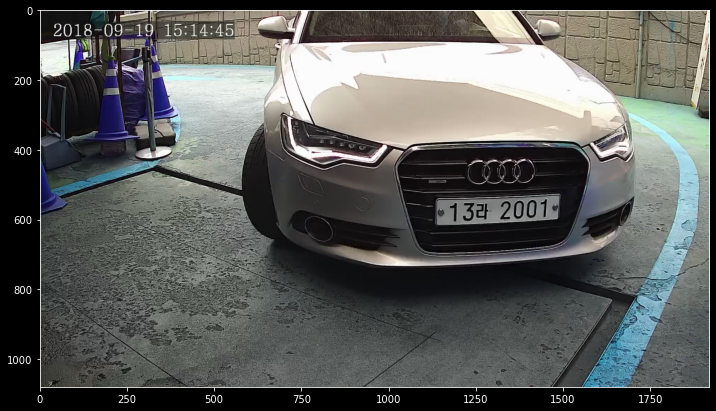

In [67]:
#Read Input Image
img_ori=cv2.imread('515.jpg')
height,width,channel=img_ori.shape

plt.figure(figsize=(12,10))
plt.imshow(img_ori,cmap='gray')

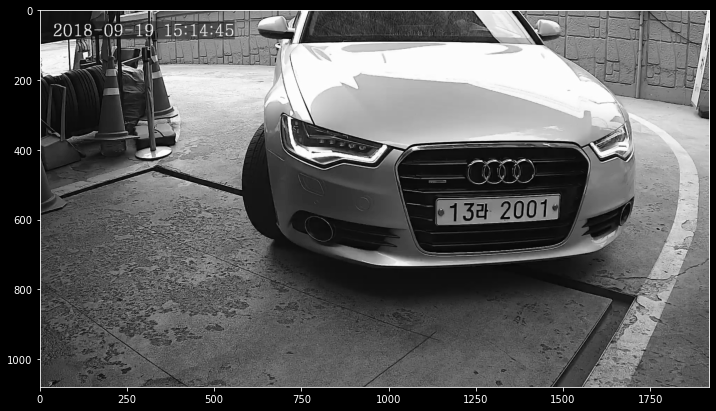

In [68]:
#Convert Image to Gray Scale
#hsv=cv2.cvtColor(img_ori,cv2.COLOR_BGR2HSV)
#gray=hsv[:,:,2]
gray=cv2.cvtColor(img_ori,cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(12,10))
plt.imshow(gray,cmap='gray')

In [69]:
#threshold only
img_thresh=cv2.adaptiveThreshold(
    gray,
    maxValue=255.0,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=19,
    C=9
)
#blurr and threshold
img_blurred=cv2.GaussianBlur(gray,ksize=(5,5),sigmaX=0)

img_blur_thresh=cv2.adaptiveThreshold(
    img_blurred,
    maxValue=255.0,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=19,
    C=9
)

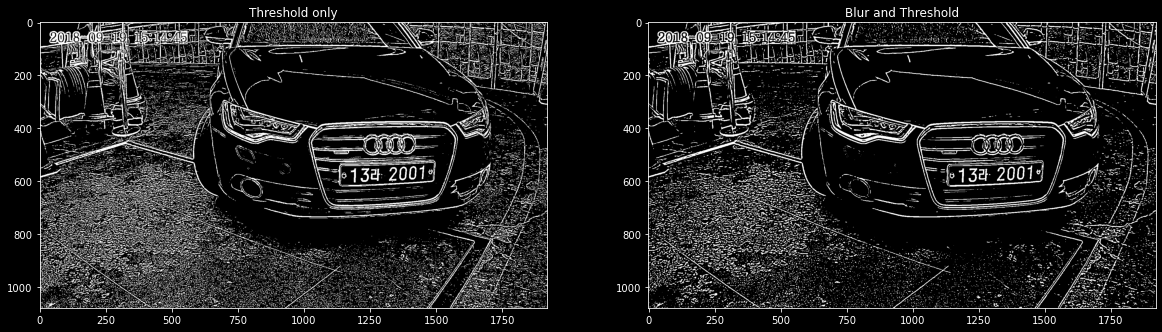

In [70]:
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.title('Threshold only')
plt.imshow(img_thresh,cmap='gray')
plt.subplot(1,2,2)
plt.title('Blur and Threshold')
plt.imshow(img_blur_thresh,cmap='gray')

In [71]:
#Find Contours
contours,_=cv2.findContours(
    img_thresh,
    mode=cv2.RETR_LIST,
    method=cv2.CHAIN_APPROX_SIMPLE
)

In [72]:
temp_result=np.zeros((height,width,channel),dtype=np.uint8)

In [73]:
cv2.drawContours(temp_result,contours=contours,contourIdx=-1,color=(255,255,255))

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

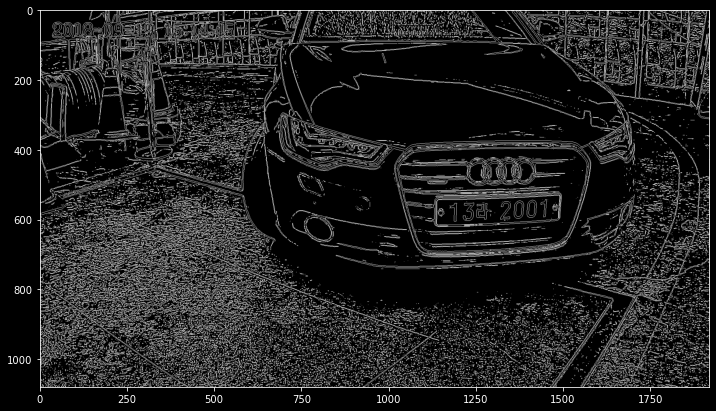

In [74]:
plt.figure(figsize=(12,10))
plt.imshow(temp_result)

In [75]:
temp_result=np.zeros((height,width,channel),dtype=np.uint8)

contours_dict=[]

for contour in contours:
    x,y,w,h=cv2.boundingRect(contour)
    cv2.rectangle(temp_result,pt1=(x,y),pt2=(x+w,y+h),color=(255,255,255),thickness=2)
    #insert to dict
    contours_dict.append({
        'contour':contour,
        'x':x,
        'y':y,
        'w':w,
        'h':h,
        'cx':x+(w/2),
        'cy':y+(h/2)
    })

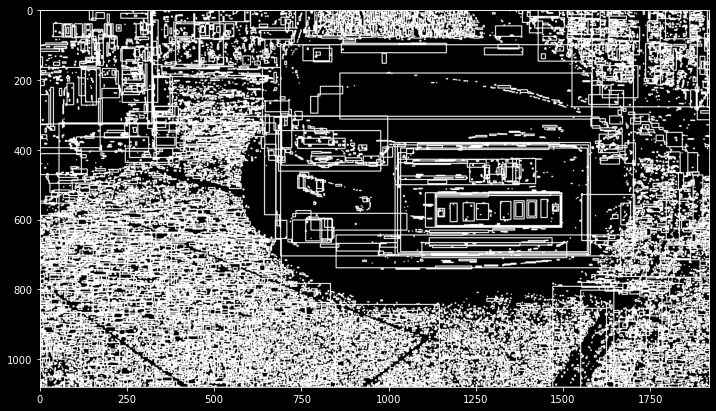

In [76]:
plt.figure(figsize=(12,10))
plt.imshow(temp_result,cmap='gray')

In [77]:
#Select Candidates By Char Size
MIN_AREA=80
MIN_WIDTH,MIN_HEIGHT=2,8
MIN_RATIO,MAX_RATIO=0.25,1.0

possible_contours=[]

cnt=0

for d in contours_dict:
    area=d['w']*d['h']
    ratio=d['w']/d['h']
    if area>MIN_AREA\
    and d['w']>MIN_WIDTH and d['h']>MIN_HEIGHT\
    and MIN_RATIO<ratio<MAX_RATIO:
        d['idx']=cnt
        cnt+=1
        possible_contours.append(d)

In [78]:
temp_result=np.zeros((height,width,channel),dtype=np.uint8)

In [79]:
for d in possible_contours:
    cv2.rectangle(temp_result,pt1=(d['x'],d['y']),pt2=(d['x']+d['w'],d['y']+d['h']),color=(255,255,255),thickness=2)
    

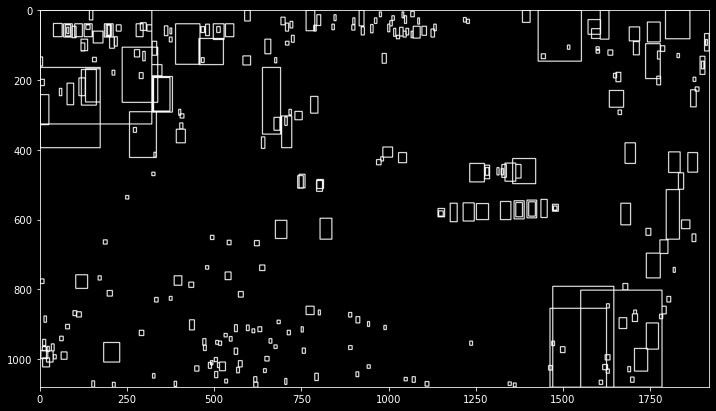

In [80]:
plt.figure(figsize=(12,10))
plt.imshow(temp_result,cmap='gray')

In [81]:
#Select candidates by Arrangement of Contours
MAX_DIAG_MULTIPLYER=5
MAX_ANGLE_DIFF=12.0
MAX_AREA_DIFF=0.5
MAX_WIDTH_DIFF=0.8
MAX_HEIGHT_DIFF=0.2
MIN_N_MATCHED=3

In [82]:
def find_chars(contour_list):
    matched_result_idx=[]
    for d1 in contour_list:
        matched_contours_idx=[]
        for d2 in contour_list:
            if d1['idx']==d2['idx']:
                continue
            dx=abs(d1['cx']-d2['cx'])
            dy=abs(d1['cy']-d2['cy'])
            
            diagonal_length1=np.sqrt(d1['w']**2+d1['h']**2)
            
            distance=np.linalg.norm(np.array([d1['cx'],d1['cy']])-np.array([d2['cx'],d2['cy']]))
            if dx==0:
                angle_diff=90
            else:
                angle_diff=np.degrees(np.arctan(dy/dx))
            area_diff=abs(d1['w']*d1['h']-d2['w']*d2['h'])/(d1['w']*d1['h'])
            width_diff=abs(d1['w']-d2['w'])/d1['w']
            height_diff=abs(d1['h']-d2['h'])/d1['h']
            
            if distance<diagonal_length1*MAX_DIAG_MULTIPLYER\
            and angle_diff<MAX_ANGLE_DIFF and area_diff<MAX_AREA_DIFF\
            and width_diff<MAX_WIDTH_DIFF and height_diff<MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])
            
        matched_contours_idx.append(d1['idx'])
        
        if len(matched_contours_idx)<MIN_N_MATCHED:
            continue
        matched_result_idx.append(matched_contours_idx)
        
        unmatched_contour_idx=[]
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])
        
        unmatched_contour=np.take(possible_contours,unmatched_contour_idx)
        
        #recursive
        recursive_contour_list=find_chars(unmatched_contour)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)
        
        break
    return matched_result_idx

In [83]:
result_idx=find_chars(possible_contours)

In [84]:
matched_result=[]

for idx_list in result_idx:
    matched_result.append(np.take(possible_contours,idx_list))

In [85]:
temp_result=np.zeros((height,width,channel),dtype=np.uint8)

In [86]:
for r in matched_result:
    for d in r:
        # cv2.drawContours(temp_result,d['contour'],-1,(255,255,255))
        cv2.rectangle(temp_result,pt1=(d['x'],d['y']),pt2=(d['x']+d['w'],d['y']+d['h']),color=(255,255,255),thickness=2)

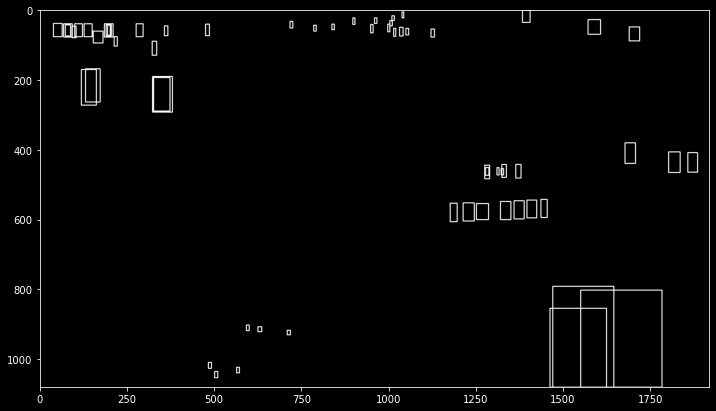

In [87]:
plt.figure(figsize=(12,10))
plt.imshow(temp_result,cmap='gray')